In [ ]:
import os
import ray
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from random import sample
from typing import Optional, Iterable

project_root = Path.cwd().resolve().parent
# os.chdir(project_root)
print("Project root:", project_root)

# Directory containing audio files organized by class
audio_directory = os.path.join(project_root, "data", "UrbanSound8K", "audio")

Project root: /home/div/vsCode/Audio_classifier_Model


In [5]:
# Binary classification directories
binary_root = project_root / "data" / "binary_classification"
positive_dir = binary_root / "gunshot_audio"
negative_dir = binary_root / "non_gunshot_audio"

positive_files = sorted(str(p) for p in positive_dir.glob("*.wav"))
negative_files = sorted(str(p) for p in negative_dir.glob("*.wav"))

print(f"Positive (gunshot) clips: {len(positive_files)}")
print(f"Negative (non-gunshot) clips: {len(negative_files)}")

positive_dataset = tf.data.Dataset.from_tensor_slices(positive_files)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_files)

positives = tf.data.Dataset.zip((positive_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive_files), dtype=tf.float32))))
negatives = tf.data.Dataset.zip((negative_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative_files), dtype=tf.float32))))

binary_data = positives.concatenate(negatives)
print(f"Total binary classification clips: {len(positive_files) + len(negative_files)}")

Positive (gunshot) clips: 521
Negative (non-gunshot) clips: 8358
Total binary classification clips: 8879
Total binary classification clips: 8879


I0000 00:00:1763121752.438908    2906 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# Analyze lengths of gunshot audio clips
gunshot_lengths = []
for wav_path in positive_files:
    samples, _ = librosa.load(wav_path, sr=16000, mono=True)
    gunshot_lengths.append(len(samples))

lengths_tensor = tf.constant(gunshot_lengths, dtype=tf.int32)

min_len = tf.reduce_min(lengths_tensor)
mean_len = tf.reduce_mean(tf.cast(lengths_tensor, tf.float32))
max_len = tf.reduce_max(lengths_tensor)

print(f"Gunshot clips: {len(gunshot_lengths)}")
print(f"Min length: {int(min_len)} samples ({int(min_len)/16000:.2f}s)")
print(f"Mean length: {float(mean_len):.1f} samples ({float(mean_len)/16000:.2f}s)")
print(f"Max length: {int(max_len)} samples ({int(max_len)/16000:.2f}s)")

Gunshot clips: 521
Min length: 2661 samples (0.17s)
Mean length: 41338.8 samples (2.58s)
Max length: 160000 samples (10.00s)


In [8]:
# Preprocess audio into spectrograms and persist for binary classification
TARGET_SAMPLE_RATE = 16000
TARGET_NUM_SAMPLES = TARGET_SAMPLE_RATE * 3  # 3 seconds
FRAME_LENGTH = 320
FRAME_STEP = 32

SPECTRO_OUTPUT_ROOT = project_root / "data" / "binary_spectrograms"
POS_SPEC_DIR = SPECTRO_OUTPUT_ROOT / "gunshot"
NEG_SPEC_DIR = SPECTRO_OUTPUT_ROOT / "non_gunshot"

for directory in (POS_SPEC_DIR, NEG_SPEC_DIR):
    directory.mkdir(parents=True, exist_ok=True)

@ray.remote
def preprocess(file_path: str, label: float):
    wav, _ = librosa.load(file_path, sr=TARGET_SAMPLE_RATE, mono=True)
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)

    wav = wav[:TARGET_NUM_SAMPLES]
    current_len = tf.shape(wav)[0]
    if current_len < TARGET_NUM_SAMPLES:
        padding = tf.zeros([TARGET_NUM_SAMPLES - current_len], dtype=tf.float32)
        wav = tf.concat([wav, padding], axis=0)

    spectrogram = tf.signal.stft(wav, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    return spectrogram, label

sample_path, sample_label = next(positives.shuffle(buffer_size=1000).as_numpy_iterator())
sample_spectrogram, _ = ray.get(preprocess.remote(sample_path.decode(), sample_label))
print("Sample spectrogram shape:", sample_spectrogram.shape)

@ray.remote
def save_spectrograms(file_paths, label, output_dir):
    saved = 0
    for file_path in file_paths:
        spec, _ = ray.get(preprocess.remote(file_path, label))
        output_path = output_dir / f"{Path(file_path).stem}.npy"
        if not output_path.exists():
            np.save(output_path, spec.numpy(), allow_pickle=False)
            saved += 1
    return saved

pos_saved = ray.get(save_spectrograms.remote(positive_files, 1.0, POS_SPEC_DIR))
neg_saved = ray.get(save_spectrograms.remote(negative_files, 0.0, NEG_SPEC_DIR))
print(f"Saved {pos_saved} gunshot spectrograms to {POS_SPEC_DIR}")
print(f"Saved {neg_saved} non-gunshot spectrograms to {NEG_SPEC_DIR}")

2025-11-14 14:15:32,929	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/div/vsCode/Audio_classifier_Model/.venv/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
/home/div/vsCode/Audio_classifier_Model/.venv/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=22839) 2025-11-14 14:15:37.635334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to us

Sample spectrogram shape: (1491, 257, 1)


(pid=22838) 2025-11-14 14:15:47.611459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=22838) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
(preprocess pid=22838) 2025-11-14 14:15:54.479514: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(preprocess pid=22838) 2025-11-14 14:15:54.479514: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Saved 521 gunshot spectrograms to /home/div/vsCode/Audio_classifier_Model/data/binary_spectrograms/gunshot
Saved 8358 non-gunshot spectrograms to /home/div/vsCode/Audio_classifier_Model/data/binary_spectrograms/non_gunshot


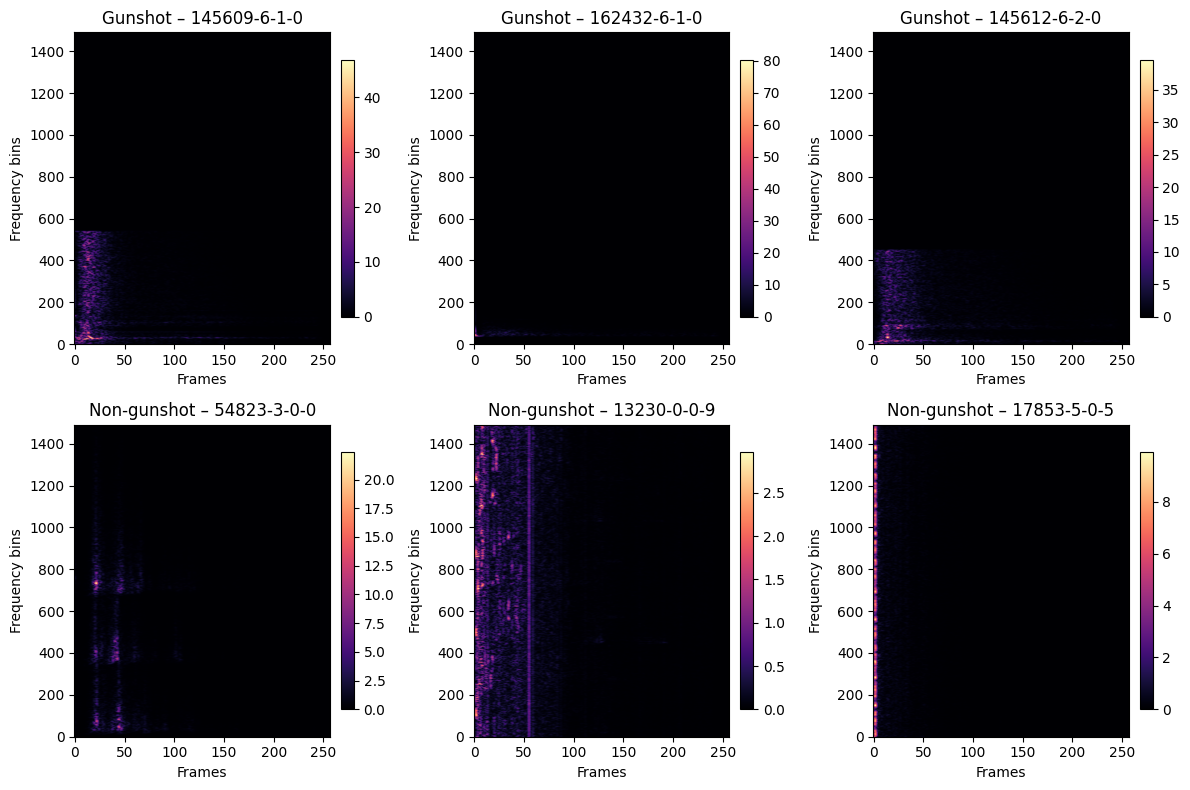

In [10]:
SPECTRO_ROOT = project_root / "data" / "binary_spectrograms"
SAMPLES_PER_CLASS = 3
LABEL_TITLES = {"gunshot": "Gunshot", "non_gunshot": "Non-gunshot"}
clips = []
for class_dir in sorted(SPECTRO_ROOT.iterdir()):
    if not class_dir.is_dir():
        continue
    npy_files = sorted(class_dir.glob("*.npy"))
    if not npy_files:
        continue
    take = npy_files if len(npy_files) <= SAMPLES_PER_CLASS else sample(npy_files, SAMPLES_PER_CLASS)
    for path in take:
        spec = np.load(path, allow_pickle=False)
        if spec.ndim == 3 and spec.shape[-1] == 1:
            spec = np.squeeze(spec, axis=-1)
        clips.append((class_dir.name, path.stem, spec))
if not clips:
    print(f"No spectrograms found in {SPECTRO_ROOT}")
else:
    ncols = 3
    nrows = int(np.ceil(len(clips) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    axes = axes.flatten()
    for ax, (raw_label, clip_name, spec) in zip(axes, clips):
        display_label = LABEL_TITLES.get(raw_label, raw_label)
        img = ax.imshow(spec, origin="lower", aspect="auto", cmap="magma")
        ax.set_title(f"{display_label} – {clip_name}")
        ax.set_xlabel("Frames")
        ax.set_ylabel("Frequency bins")
        fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    for ax in axes[len(clips):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [11]:
binary_data.as_numpy_iterator().next()

(b'/home/div/vsCode/Audio_classifier_Model/data/binary_classification/gunshot_audio/102305-6-0-0.wav',
 np.float32(1.0))

In [39]:
# data.as_numpy_iterator().next()

def _librosa_preprocess(path):
    path = path.decode()
    wav, _ = librosa.load(path, sr=TARGET_SAMPLE_RATE, mono=True)
    wav = wav[:TARGET_NUM_SAMPLES]
    if wav.shape[0] < TARGET_NUM_SAMPLES:
        wav = np.pad(wav, (0, TARGET_NUM_SAMPLES - wav.shape[0]), mode="constant")
    n_fft = 512
    hop_length = FRAME_STEP
    target_time = 1491
    target_freq = 257
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, center=True)
    spec = np.abs(stft).T
    if spec.shape[0] > target_time:
        spec = spec[:target_time, :]
    elif spec.shape[0] < target_time:
        pad_rows = target_time - spec.shape[0]
        spec = np.pad(spec, ((0, pad_rows), (0, 0)), mode="constant")
    if spec.shape[1] > target_freq:
        spec = spec[:, :target_freq]
    elif spec.shape[1] < target_freq:
        pad_cols = target_freq - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_cols)), mode="constant")
    spec = spec.astype(np.float32)
    spec = np.expand_dims(spec, axis=-1)
    return spec


def preprocess_tf(file_path, label):
    spectrogram = tf.numpy_function(_librosa_preprocess, [file_path], tf.float32)
    spectrogram.set_shape([1491, 257, 1])
    return spectrogram, label


# Creating a Tensorflow Data Pipeline
data = binary_data.map(preprocess_tf)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [40]:
print(f"{len(data)} batches in the dataset.")
print(f"{len(data)*.8} samples for training, {len(data)*.2} samples for testing.")

1110 batches in the dataset.
888.0 samples for training, 222.0 samples for testing.


In [41]:
# Split into Training and Testing Partitions
train = data.take(int(len(data)*0.8))
test = data.skip(int(len(data)*0.8)).take(int(len(data)*0.2))

print(f"Training batches: {len(train)}")
print(f"Testing batches: {len(test)}")

Training batches: 888
Testing batches: 222


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Building the CNN Model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

/home/div/vsCode/Audio_classifier_Model/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6019376)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │     6,019,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,021,857 (22.97 MB)

 Trainable params: 6,021,857 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train, epochs=10, validation_data=test)

Epoch 1/10


2025-11-14 15:21:12.272895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 551 of 1000
2025-11-14 15:21:23.194472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-14 15:21:23.194472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


  3/888 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - loss: 5.9612 - precision_3: 0.3500 - recall_3: 0.3056

I0000 00:00:1763130095.218272    3182 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 3.0986 - precision_3: 0.7310 - recall_3: 0.5711

2025-11-14 15:24:29.897082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
(raylet) [2025-11-14 15:24:37,303 E 22649 22649] (raylet) node_manager.cc:3252: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: be2a7267d351603f513eb7822a42aae35e6930bb4518d8a92bb75487, IP: 172.21.159.44) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.21.159.44`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consi